In [1]:
import pandas as pd 
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

# read in data

based on kaggle data from: https://www.kaggle.com/ronitf/heart-disease-uci

In [3]:
heart = pd.read_csv("heart.csv")  # load kaggle heart data  

In [4]:
heart["cp"] = np.where(heart["cp"] > 0, 1, 0)  # presence vs absence only 

In [5]:
heart.head() # shows us the first few entries of a dataframe

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,1,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# data properties

here we just want to explore the data. are our cases and controls balanced? are there any apparent biases? what is the relationship between our input variables and our case status? are there any that look particularly useful or not useful? 

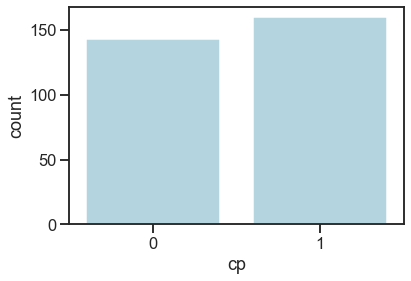

In [6]:
# a countplot is useful for categorical data, for example looking at the number of cases we have, 
# or the number of sexes we have 

sns.countplot(x="cp", data=heart, color="lightblue")
plt.show()

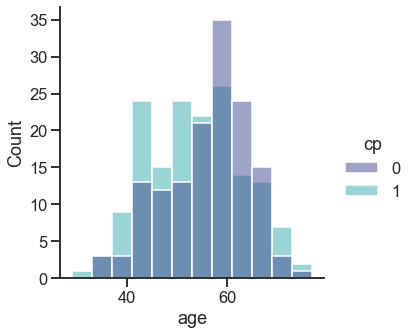

In [11]:
# a histogram (in python, a displot) can show us how quantitative variables change 
# the hue parameter lets us color our histogram (or other type of plot) by a categorical data variable
# note seaborn comes with some preselected color palettes that are worth exploring to make nice plots

sns.displot(x="age", data=heart, hue="cp", palette=sns.color_palette("mako", 2))
plt.show()

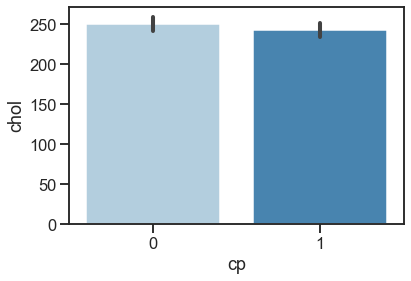

In [12]:
# seaborn can also automatically calculate mean and average bars for quantitative data 
# in formats like a barplot 

sns.barplot(y="chol", x="cp", data=heart, palette=sns.color_palette("Blues", 2))
plt.show()

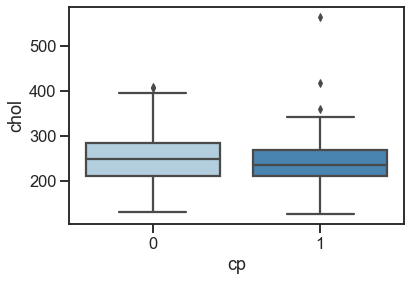

In [13]:
# boxplots, however, can show more about the distribution of the underlying data as 
# function of a categorical data variable 

sns.boxplot(y="chol", x="cp", data=heart, palette=sns.color_palette("Blues", 2))
plt.show()

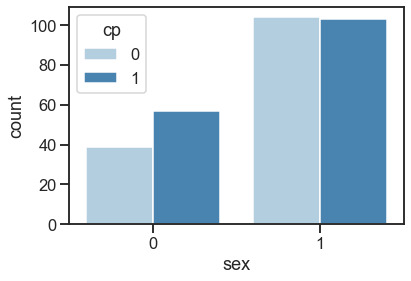

In [14]:
# you should pay special attention to interactions of variables that might be obvious sources of 
# bias in your data. sometimes these are unavoidable, but they're always good to know about
# and to discuss in any writeups you do 

sns.countplot(x="sex", data=heart, palette=sns.color_palette("Blues", 2), hue="cp")
plt.show()

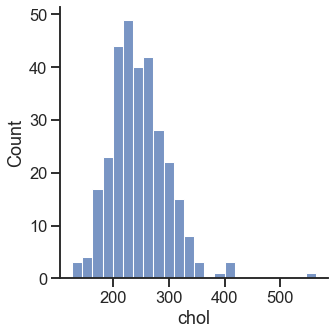

In [16]:
# you might also want to look for extreme outliers, that might affect your model's performance 

sns.displot(x="chol", data=heart)
plt.show()

# statistics 

it might also be useful to quantify your data by descriptive statistics, calculating them based on different quantitative or categorical variables

In [17]:
heart.groupby("cp")["age"].median()

cp
0    57
1    54
Name: age, dtype: int64

In [18]:
heart.groupby(["cp"])["sex"].value_counts()

cp  sex
0   1      104
    0       39
1   1      103
    0       57
Name: sex, dtype: int64

In [19]:
heart["cp"].nunique()

2

# logistic regression 

a logistic regression is a simple model that predicts binary outcome (so chest pain, or no chest pain) based on input variables. It's roughly described as this (where ~ can be thought of as meaning, "function of"): 

y (outcome) ~ logit( X (input variables) )

a logistic regression is divided into two steps, training and testing. the first is teaching the model the relationship between the input variables and outcome. the second step tests to see whether this relationship applies to data outside the training set.  

In [7]:
# here we are separating our data into outcome and input variables 

Y = heart[["cp"]]
X = heart.loc[:, heart.columns != "cp"]

## test train split

In [8]:
# we must split our data into test/train set. 
# Python does this randomly for us, but the random state variable ensures that the same "random"
# set is chosen each time. 
# you can try exploring different test/train percentages. usually people pick this on some set of 
# what's common for their field and the amount of data they have available. 70/30 or 80/20 is common. 

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)

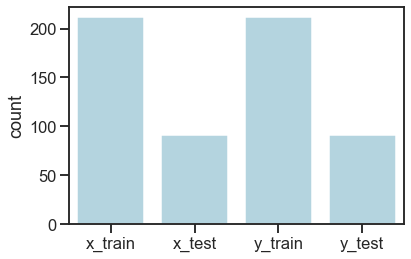

In [9]:
sns.barplot(x=["x_train", "x_test", "y_train", "y_test"], 
            y=[len(x_train), len(x_test), len(y_train), len(y_test)],
           color="lightblue")
plt.ylabel("count")
plt.show()

## test/train analysis

it's good practice to check that your test/train data is largely balanced. you might have problems with your model if the training data doesn't have enough cases, for example 

In [10]:
y_test["cp"].value_counts(normalize=True)  # normalize just transforms the counts into the percentage of cases/controls

1    0.549451
0    0.450549
Name: cp, dtype: float64

In [11]:
y_train["cp"].value_counts(normalize=True)

1    0.518868
0    0.481132
Name: cp, dtype: float64

## run model 

### define model 

In [12]:
logit = LogisticRegression(solver="lbfgs", max_iter=1000) # first we define the model, with some default parameters

### train

In [13]:
x_train.values  # we must transform the pandas data to numpy arrays for input into the model 

array([[ 62.,   1., 128., ...,   0.,   2.,   1.],
       [ 69.,   1., 160., ...,   1.,   2.,   1.],
       [ 61.,   1., 140., ...,   1.,   3.,   0.],
       ...,
       [ 56.,   1., 120., ...,   0.,   3.,   1.],
       [ 47.,   1., 138., ...,   0.,   2.,   1.],
       [ 58.,   1., 120., ...,   0.,   2.,   0.]])

In [14]:
logit.fit(x_train.values, y_train.values.reshape(-1,))

LogisticRegression(max_iter=1000)

### test

In [15]:
y_pred = logit.predict(x_test) # we then test it on our held out data

In [16]:
y_pred

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0])

## evaluate

evaluating a model is really important step that asks how well our model works on data outside the training set. 

In [17]:
# a confusion matrix is a helpful way of understanding the number our model 
# is correctly or incorreclty classifying, and whether there is one category the model is favoring
# This can help diagnose problems with the model. For example, it might just classify 
# everything as a control if there isn't enough cases to learn from in the training set 

cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

In [18]:
cnf_matrix

array([[30, 11],
       [12, 38]])

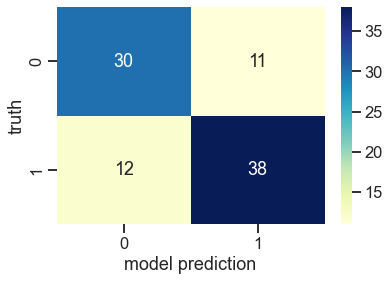

In [19]:
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show() 

In [20]:
accuracy_score(y_test, y_pred) # the percentage of correctly classified samples 

0.7472527472527473

In [21]:
# RMSE is also useful in knowing how well your model is describing your data

mean_squared_error(y_test, y_pred) 

0.25274725274725274

see for a RSME example  https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2F%40mygreatlearning%2Frmse-what-does-it-mean-2d446c0b1d0e&psig=AOvVaw0wjeuMNkOeslJ9SAbaj5yn&ust=1631148487269000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJi9xeOT7vICFQAAAAAdAAAAABAD

In [22]:
# lastly, we might want to learn about the precision and recall 
# precision (tp/(tp+fp)) -- we are accurately naming cases
# recall (tp/(tp+fn)) -- we aren't missing any cases 
# we want both to be close to 1-- higher the better. in biomedical applications, you want to weigh
# the two against each other, you want to catch a lot of cases, but you don't want to classify
# a person as having a disease if they don't have it 

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        41
           1       0.78      0.76      0.77        50

    accuracy                           0.75        91
   macro avg       0.74      0.75      0.75        91
weighted avg       0.75      0.75      0.75        91



# check for biases in results

is there some group that the model is consistently misclassifying? could the results be affected by an outlier? it's always good to see if there are similarities between incorrectly classified groups 

In [ ]:
x_test["true"] = y_test["cp"]
x_test["predicted"] = y_pred

In [ ]:
x_test["correct"] = np.where(x_test["true"] == x_test["predicted"], True, False)

In [ ]:
sns.countplot(x="correct", data=x_test, hue="sex", palette=sns.color_palette("Blues", 2))
plt.show()

In [ ]:
sns.displot(x="age", hue="correct", data=x_test, palette=sns.color_palette("mako", 2))
plt.show()

# cross validated logistic regression

In [62]:
# define the cross validation splits 
cv = KFold(n_splits=20, random_state=1, shuffle=True)

In [63]:
# keep the same logistic regression model 
logit = LogisticRegression(solver="lbfgs", max_iter=1000) 

In [64]:
Y = heart[["cp"]].values
X = heart.loc[:, heart.columns != "cp"].values

In [65]:
Y = Y.reshape(-1)

In [66]:
X.shape, Y.shape

((303, 13), (303,))

In [67]:
# run the model over the entire set of data, for the splits we defined above
scores = cross_val_score(logit, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

In [68]:
scores

array([0.625     , 0.8125    , 0.625     , 0.6       , 0.86666667,
       0.73333333, 0.86666667, 0.66666667, 0.73333333, 0.93333333,
       0.86666667, 0.86666667, 0.73333333, 0.73333333, 0.8       ,
       0.73333333, 0.8       , 0.6       , 0.8       , 0.73333333])

In [69]:
scores.mean()

0.7564583333333333

# neural network

### data preparation 
is the data suited for a neural network? see obesity prediction exercise 

### test/train split

### defining the model 

### training the model 

#### evaluating training 